In [1]:
## Exercise 5: Regularized Linear Regression and Bias-Variance

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

Loading and Visualizing Data ...


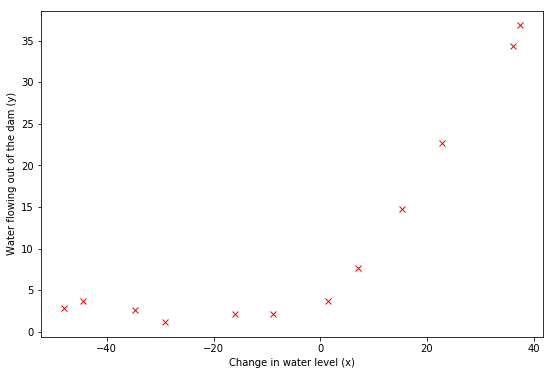

In [2]:
## Part 1: Loading and Visualizing Data

# Load Training Data
print('Loading and Visualizing Data ...')

# Load from ex5data1:
# You will have X, y, Xval, yval, Xtest, ytest
data = loadmat('../ex5/ex5data1.mat')
X = data['X']
y = data['y'].ravel()
Xval = data['Xval']
yval = data['yval'].ravel()
Xtest = data['Xtest']
ytest = data['ytest'].ravel()

# m = Number of examples
m = len(X)

# Plot training data
plt.figure(figsize=(9, 6))
plt.plot(X, y, 'rx', markersize=6, linewidth=2)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
None

In [3]:
## Part 2: Regularized Linear Regression Cost

def linearRegCostFunction(X, y, theta, lambda_):
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    m = len(y)
    
    h = X.dot(theta.T)
    diff = h - y
    
    theta = np.r_[0, theta[1:]]
    
    J = diff.dot(diff) / (2 * m)
    if theta.ndim == 1:
        J += lambda_ * theta.dot(theta) / (2 * m)
    else:
        J += lambda_ * sum(theta**2) / (2 * m)
    
    grad = X.T.dot(diff) / m
    grad += lambda_ * theta / m
    
    return J, grad

In [4]:
theta = np.array([1, 1])
J, _ = linearRegCostFunction(np.c_[np.ones(m), X], y, theta, 1)

print('Cost at theta = [1 1]: {:f}'
      '\n(this value should be about 303.993192)'.format(J))

Cost at theta = [1 1]: 303.993192
(this value should be about 303.993192)


In [5]:
## Part 3: Regularized Linear Regression Gradient

theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.c_[np.ones(m), X], y, theta, 1)

np.set_printoptions(precision=6)
print('Gradient at theta = [1 1]:  {} '
      '\n(this value should be about [-15.303016 598.250744])'.format(grad))

Gradient at theta = [1 1]:  [-15.303016 598.250744] 
(this value should be about [-15.303016 598.250744])


In [6]:
## Part 4: Train Linear Regression

def traingLinearReg(X, y, lambda_):
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    # Initialize Theta
    initial_theta = np.zeros(X.shape[1])
    
    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)
    
    # Now, costFunction is a function that takes in only one argument
    optimset = {'disp': False, 'maxiter': 200}
    
    # Minimize using fmincg
    result = minimize(costFunction, initial_theta, 
                      method='CG', jac=True, options=optimset)
    theta = result['x']
    
    return theta

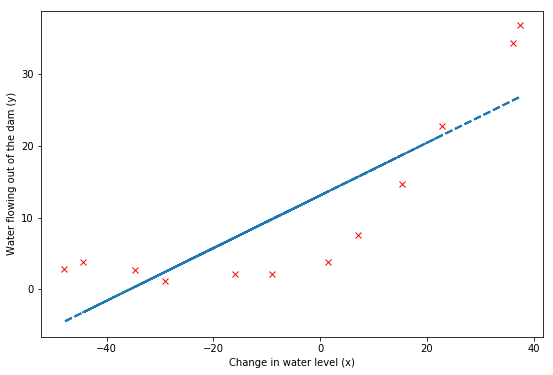

In [7]:
# Train linear regression with labmda = 0
lambda_ = 0
theta = traingLinearReg(np.c_[np.ones(m), X], y, lambda_)

# Plot fit over the data
plt.figure(figsize=(9, 6))
plt.plot(X, y, 'rx', markersize=6, linewidth=1.5)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(X, np.c_[np.ones(m), X].dot(theta.T), '--', linewidth=2)
None

In [8]:
def learningCurve(X, y, Xval, yval, lambda_):
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    # Number of traning examples
    m = len(X)
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(m):
        X_ = X[:i + 1]
        y_ = y[:i + 1]
        
        t = traingLinearReg(X_, y_, lambda_)
        
        error_train[i], _ = linearRegCostFunction(X_, y_, t, 0)
        error_val[i], _ = linearRegCostFunction(Xval, yval, t, 0)
    
    return error_train, error_val

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	205.121096
  	2		0.000000	110.300366
  	3		3.286595	45.010232
  	4		2.842678	48.368911
  	5		13.154049	35.865141
  	6		19.443963	33.829957
  	7		20.098522	31.970987
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


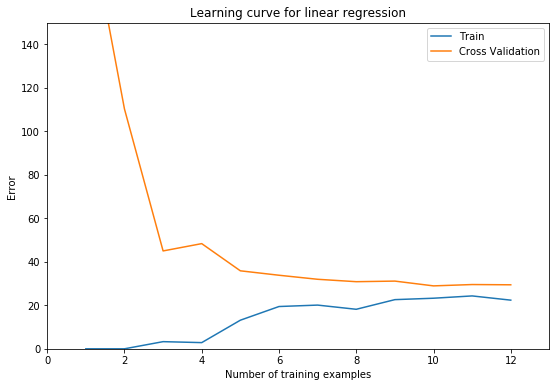

In [9]:
## Part 5: Learning Curve for Linear Regression

lambda_ = 0
error_train, error_val = learningCurve(
    np.c_[np.ones(m), X], y, 
    np.c_[np.ones(Xval.shape[0]), Xval], yval, 
    lambda_)

plt.figure(figsize=(9, 6))
plt.plot(range(1, m + 1), error_train, range(1, m + 1), error_val)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 150])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t{:d}\t\t{:f}\t{:f}'.format(
        i+1, error_train[i], error_val[i]))


In [10]:
## Part 6: Feature Mapping for Polynomial Regression

def polyFeatrues(X, p):
    X = X.squeeze()
    
    X_poly = np.zeros((X.size, p))
    
    X_poly[:, 0] = X
    for i in range(1, p):
        X_poly[:, i] = X * X_poly[:, i - 1]

    return X_poly


def featureNormalize(X):
    
    X_norm = X
    
    mu = np.mean(X, axis=0)
    X_norm -= mu
    
    sigma = np.std(X, axis=0, ddof=1)
    X_norm /= sigma
    
    return X_norm, mu, sigma

In [11]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatrues(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)  # Normalize
X_poly = np.c_[np.ones(m), X_poly]            # Add Ones

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatrues(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.c_[np.ones(X_poly_test.shape[0]), X_poly_test]  # Add Ones

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatrues(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.c_[np.ones(X_poly_val.shape[0]), X_poly_val]     # Add Ones

print('Normalized Training Examples 1:')
print('  {}  '.format(X_poly[0]))

Normalized Training Examples 1:
  [ 1.       -0.362141 -0.755087  0.182226 -0.70619   0.306618 -0.590878
  0.344516 -0.508481]  


In [12]:
## Part 7: Learning Curve for Polynomial Regression

def plotFit(min_x, max_x, mu, sigma, theta, p):
    x = np.arange(min_x - 15, max_x + 25, 0.05)
    
    # Map the X values
    X_poly = polyFeatrues(x, p)
    X_poly -= mu
    X_poly /= sigma
    
    # Add ones
    X_poly = np.c_[np.ones(x.shape[0]), X_poly]
    
    # Plot
    plt.plot(x, X_poly.dot(theta.T), '--', linewidth=2)

Polynomial Regression (lambda = 0)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	160.721900
  	2		0.000000	160.121510
  	3		0.000000	61.755005
  	4		0.000000	61.928895
  	5		0.000000	6.599170
  	6		0.000000	10.647257
  	7		0.000000	27.988565
  	8		0.062482	8.127322
  	9		0.000215	31.929648
  	10		0.038651	24.959294
  	11		0.035832	30.638125
  	12		0.085192	8.225258


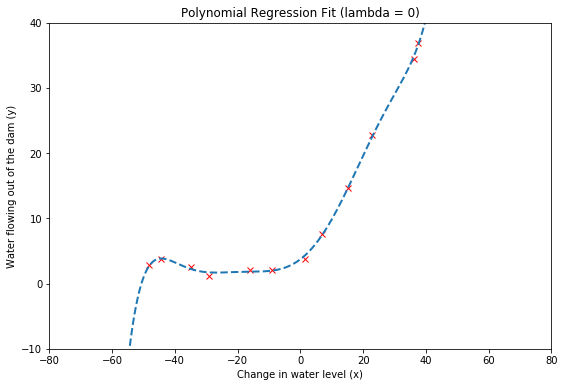

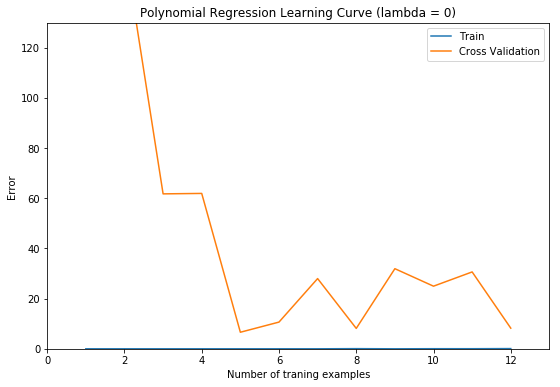

In [13]:
lambda_ = 0
theta = traingLinearReg(X_poly, y, lambda_)

# Plot training data and fit
plt.figure(figsize=(9, 6))
plt.plot(X, y, 'rx', markersize=6, linewidth=2)
plotFit(min(X), max(X), mu, sigma, theta, p)
plt.title('Polynomial Regression Fit (lambda = {:g})'.format(lambda_))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.axis([-80, 80, -10, 40])

plt.figure(figsize=(9, 6))
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
plt.plot(range(1, m + 1), error_train, range(1, m + 1), error_val)
plt.title('Polynomial Regression Learning Curve (lambda = {:g})'.format(lambda_))
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of traning examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 130])

print('Polynomial Regression (lambda = {:g})\n'.format(lambda_))
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t{:d}\t\t{:f}\t{:f}'.format(i+1, error_train[i], error_val[i]))

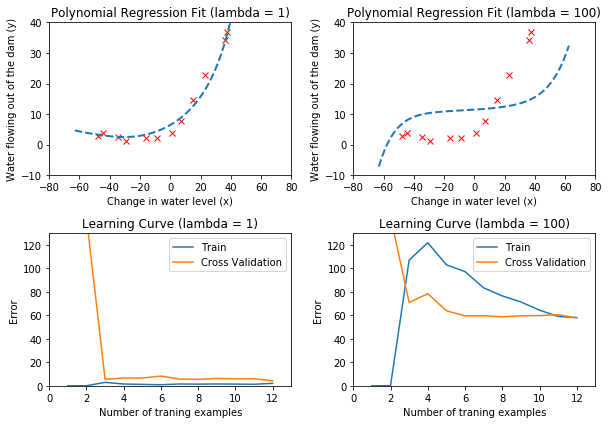

In [14]:
## Optional Exercise: Adjusting the regularization parameter

fig = plt.figure(figsize=(8.7, 6))

lambda_vals = (1, 100)
for i, lambda_ in enumerate(lambda_vals):
    theta = traingLinearReg(X_poly, y, lambda_)
    
    fig.add_subplot(2, 2, i + 1)
    plt.plot(X, y, 'rx', markersize=6, linewidth=2)
    plotFit(min(X), max(X), mu, sigma, theta, p)
    plt.title('Polynomial Regression Fit (lambda = {:g})'.format(lambda_))
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.axis([-80, 80, -10, 40])

    fig.add_subplot(2, 2, i + 3)
    error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
    plt.plot(range(1, m + 1), error_train, range(1, m + 1), error_val)
    plt.title('Learning Curve (lambda = {:g})'.format(lambda_))
    plt.legend(['Train', 'Cross Validation'])
    plt.xlabel('Number of traning examples')
    plt.ylabel('Error')
    plt.axis([0, 13, 0, 130])

plt.tight_layout()

In [15]:
## Part 8: Validation for Selecting Lambda

def validationCurve(X, y, Xval, yval):
    
    # Selected values of lambda
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    
    error_train = np.zeros(len(lambda_vec))
    error_val = np.zeros(len(lambda_vec))
    
    for i, lambda_ in enumerate(lambda_vec):
        theta = traingLinearReg(X, y, lambda_)
        error_train[i], _ = linearRegCostFunction(X, y, theta, 0)
        error_val[i], _ = linearRegCostFunction(Xval, yval, theta, 0)
        
    return lambda_vec, error_train, error_val

lambda		Train Error	Validation Error
 0.000000	0.087471	7.885979
 0.001000	0.112874	10.030630
 0.003000	0.171232	16.357770
 0.010000	0.221516	16.952205
 0.030000	0.281865	12.827187
 0.100000	0.459331	7.586874
 0.300000	0.921792	4.636774
 1.000000	2.076179	4.260620
 3.000000	4.901348	3.822899
 10.000000	16.092210	9.945504


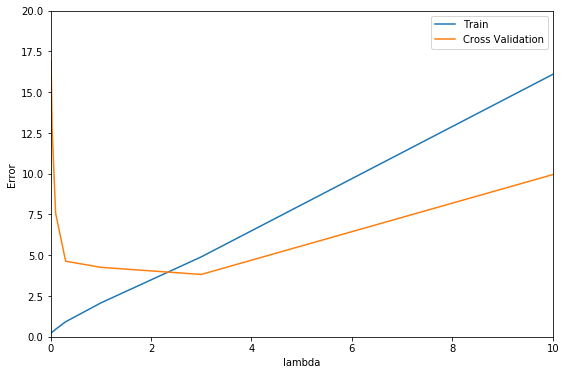

In [16]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.figure(figsize=(9, 6))
plt.plot(lambda_vec, error_train, lambda_vec, error_val)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('lambda')
plt.ylabel('Error')
plt.axis([0, 10, 0, 20])

print('lambda\t\tTrain Error\tValidation Error')
for i, lambda_ in enumerate(lambda_vec):
    print(' {:f}\t{:f}\t{:f}'.format(lambda_, error_train[i], error_val[i]))

Test error: 3.8599 (with best lambda = 3)


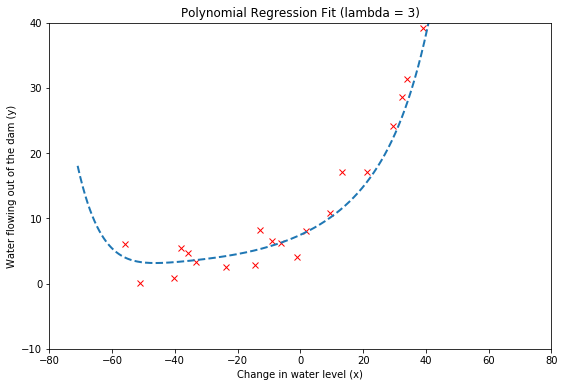

In [17]:
## Optional Exercise: Computing test set error

lambda_best = lambda_vec[np.argmin(error_val)]
theta = traingLinearReg(X_poly, y, lambda_best)
error_test, _ = linearRegCostFunction(X_poly_test, ytest, theta, 0)

plt.figure(figsize=(9, 6))
plt.plot(Xtest, ytest, 'rx', markersize=6, linewidth=2)
plotFit(min(Xtest), max(Xtest), mu, sigma, theta, p)
plt.title('Polynomial Regression Fit (lambda = {:g})'.format(lambda_best))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.axis([-80, 80, -10, 40])

print('Test error: {:.4f} (with best lambda = {:g})'.format(
    error_test, lambda_best))

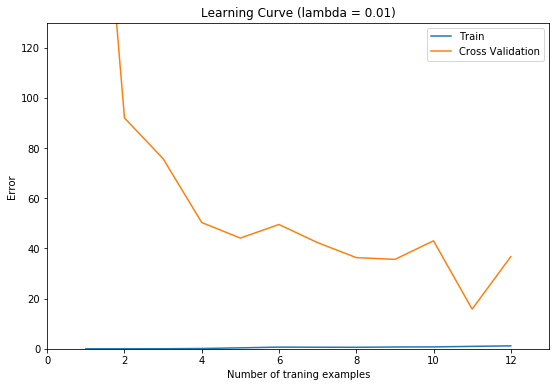

In [18]:
## Optional Exercise: Plotting learning curves with randomly selected examples
#  learn theta using the randomly chosen training set 
#  evaluate theta on the randomly chosen training set and cross validation set.

X_all = np.r_[X, Xval]
y_all = np.r_[y, yval]

m = 12
lambda_ = 0.01
error_train_ensemble = 0
error_val_ensemble = 0
for i in range(5):
    # Randomly choose training set and validation set
    sel = np.random.permutation(X_all.shape[0])
    X_train = X_all[sel[:m]]
    y_train = y_all[sel[:m]]
    X_val = X_all[sel[m:]]
    y_val = y_all[sel[m:]]
    
    X_poly_train = polyFeatrues(X_train, p)
    X_poly_train, mu, sigma = featureNormalize(X_poly_train)
    X_poly_train = np.c_[np.ones(m), X_poly_train]
    
    X_poly_val = polyFeatrues(X_val, p)
    X_poly_val -= mu
    X_poly_val /= sigma
    X_poly_val = np.c_[np.ones(X_val.shape[0]), X_poly_val]
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(m):
        X_ = X_poly_train[:i + 1]
        y_ = y_train[:i + 1]
        
        t = traingLinearReg(X_, y_, lambda_)
        
        error_train[i], _ = linearRegCostFunction(X_, y_, t, 0)
        error_val[i], _ = linearRegCostFunction(X_poly_val, y_val, t, 0)
        
    error_train_ensemble += error_train
    error_val_ensemble += error_val
    

error_train_ensemble /= 5
error_val_ensemble /= 5

plt.figure(figsize=(9, 6))
plt.plot(range(1, m + 1), error_train_ensemble, range(1, m + 1), error_val_ensemble)
plt.title('Learning Curve (lambda = {:g})'.format(lambda_))
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of traning examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 130])
None